In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


[2018-01-27 16:29:28,658] Making new env: CartPole-v0


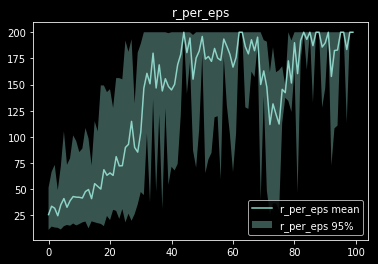

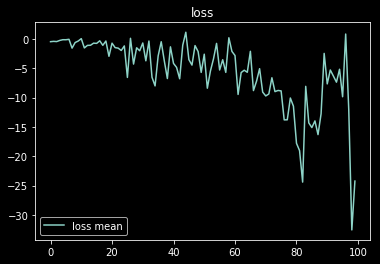

In [58]:
# Discrete task

from rl.algs import environment
from rl.algs import pg
from rl.algs import plotter

NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 1000
env = environment.Environment(max_episode_steps=MAX_STEPS_PER_EPISODE)
model = pg.DiscreteActionModel(env.ob_dim, env.ac_dim)
policy = pg.Policy(model, lr=0.005)

plt = plotter.Plotter()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  for name, metrics in m.items():
    plt.add_data(name, i, metrics)

plt.line_plot()
plt.render()


In [59]:
# Show an episode of the final policy
env.visualize(policy, num_episodes=3)


Reward: mean 200.00, std 0.00 over 3 episodes.


[200.0, 200.0, 200.0]

[2018-01-28 13:42:13,761] Making new env: RoboschoolInvertedPendulum-v1


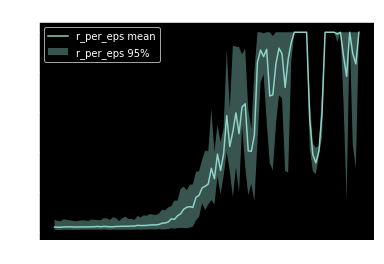

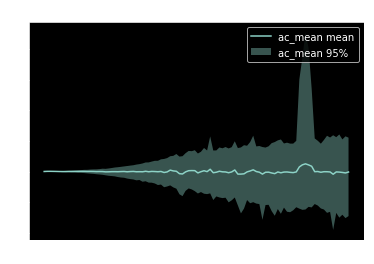

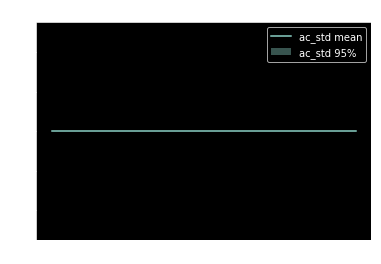

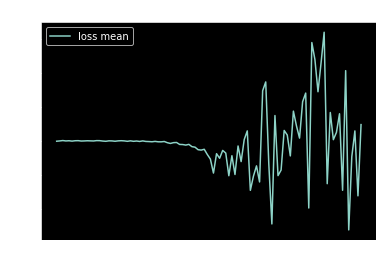

In [5]:
# Continuous task

import roboschool

from rl.algs import environment
from rl.algs import pg
from rl.algs import plotter

ENV_NAME = 'RoboschoolInvertedPendulum-v1'
#ENV_NAME = 'BipedalWalker-v2'
NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 5000
env = environment.Environment(
    env_name=ENV_NAME, max_episode_steps=MAX_STEPS_PER_EPISODE)
model = pg.ContinuousActionModel(env.ob_dim, env.ac_dim)
policy = pg.Policy(model, lr=0.001)
policy_snapshots = pg.PolicySnapshots()

plt = plotter.Plotter()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  for name, metrics in m.items():
    plt.add_data(name, i, metrics)
  
  if i % 5 == 0:
    policy_snapshots.snapshot(i, policy)

plt.line_plot()
plt.render()


In [6]:
# Roboschool does not close properly on env.render(close=True)
# Workaround by creating new env and deleting it.
env = environment.Environment(
    ENV_NAME, max_episode_steps=MAX_STEPS_PER_EPISODE)
env.visualize(policy_snapshots.get(80))
del env

[2018-01-28 13:47:58,930] Making new env: RoboschoolInvertedPendulum-v1


Reward: mean 1000.00, std 0.00 over 1 episodes.


In [9]:
# Scratchpad
import torch as th

mu = th.Tensor([0, 0.5, 1.0])
std = th.Tensor([1.0, 1.0, 1.0])

d = th.distributions.Normal(mu, std)
print(d)
a = th.Tensor([0, 0, 1.0])
th.exp(d.log_prob(a))

l = th.distributions.Normal(-0.2649, 1.1248).log_prob(-0.8086)
th.exp(th.Tensor([l]))



[4, 3, 2, 1]